# Image Classification with SGDClassifier

In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

# เตรียมชุดข้อมูล

ฟังก์ชัน resize_all() นี้จะทำหน้าที่แปลงรูปภาพที่จัดเก็บไว้ในโฟลเดอร์ของเครื่องคอมพิวเตอร์<br>ให้เป็นไฟล์ .pkl พร้อมกับปรับขนาดรูปภาพตามที่กำหนด

In [2]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [3]:
data_path = r'C:\MLOps323\Project_Setup\images'
os.listdir(data_path)

['flood', 'footpath', 'safety', 'traffic', 'trash']

In [4]:
base_name = 'teamCC'
width = 180
 
include = {'flood', 'footpath', 'safety', 'traffic', 'trash'}

In [5]:
# resize_all(src=data_path, pklname=base_name, width=width, include=include)

โหลดชุดข้อมูลที่บันทึกเป็น .pkl แล้วมาใช้งานพร้อมกับตรวจสอบความถูกต้องของข้อมูล <br>
ว่ายังมีจำนวนรูป และ Label ตรงกับโฟลเดอร์ต้นฉบับหรือไม่

In [6]:
from collections import Counter
 
data = joblib.load(fr'C:\basic_mlops323\\{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  258
keys:  ['description', 'label', 'filename', 'data']
description:  resized (180x180)animal images in rgb
image shape:  (180, 180, 3)
labels: ['flood' 'footpath' 'safety' 'traffic' 'trash']


Counter({'flood': 26,
         'footpath': 96,
         'safety': 74,
         'traffic': 29,
         'trash': 33})

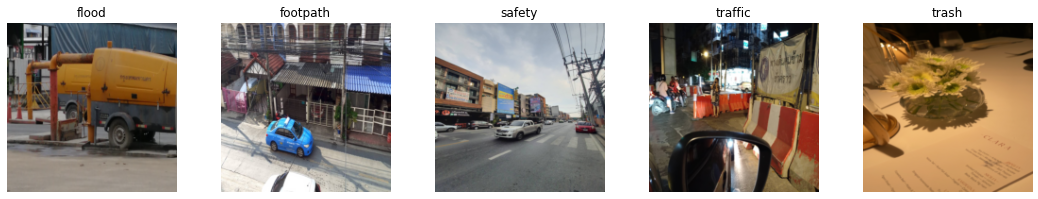

In [7]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

แบ่งข้อมูลออกเป็น Train Set และ Test Set สำหรับใช้สอนและทดสอบโมเดล

In [8]:
X = np.array(data['data'])
y = np.array(data['label'])

In [9]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

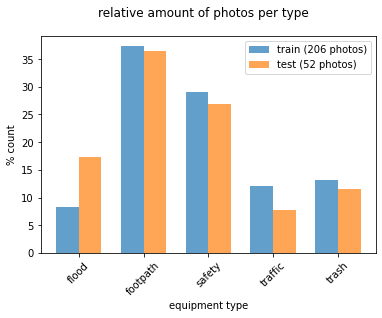

In [10]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

# Transform ข้อมูลรูปภาพ

แปลงข้อมูลรูปภาพโดยใช้ Histogram of Oriented Gradients (HOG) เพื่อทำ Feature Reduction <br>
หรือก็คือการลดความซับซ้อนของข้อมูลโดยยังคงรักษาคุณลักษณะสำคัญไว้ให้ได้มากที่สุด และการจะทำ HOG นั้น <br>
จำเป็นจะต้องแปลงรูปภาพเป็น Grayscale ก่อน

In [11]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

แปลงข้อมูล X_train และ X_Test

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2),
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()

In [25]:
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(206, 4356)


In [26]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

print(X_test_prepared.shape)

(52, 4356)


# SGDClassifier Model

In [27]:
sgd_clf = SGDClassifier(loss='log', random_state=42, max_iter=1000, tol=1e-3,)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(loss='log', random_state=42)

# Testing and Evaluation

In [28]:
y_pred = sgd_clf.predict(X_test_prepared)
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

Percentage correct:  36.53846153846154


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, confusion_matrix

In [30]:
sgd_report = classification_report(y_test, y_pred, target_names=np.unique(y_test), zero_division=False)
print(sgd_report)

              precision    recall  f1-score   support

       flood       0.50      0.11      0.18         9
    footpath       0.57      0.68      0.62        19
      safety       0.38      0.21      0.27        14
     traffic       0.11      0.25      0.15         4
       trash       0.10      0.17      0.12         6

    accuracy                           0.37        52
   macro avg       0.33      0.29      0.27        52
weighted avg       0.41      0.37      0.36        52



In [31]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix: Gaussian NB',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

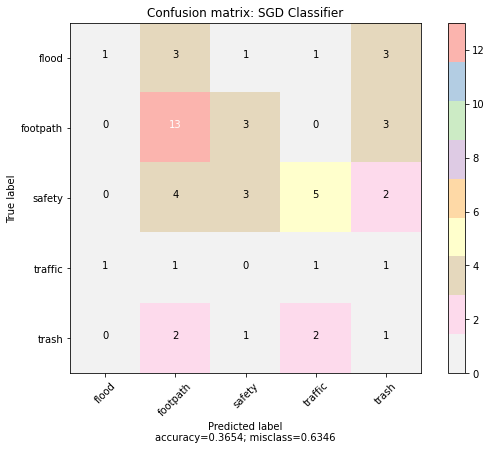

In [32]:
cm = confusion_matrix(y_test, y_pred, labels=np.unique(data['label']))
target_names = np.unique(data['label']).tolist()
plot_confusion_matrix(cm, target_names, title='Confusion matrix: SGD Classifier', cmap='Pastel1_r', normalize=False)

# Test on Real Image

In [33]:
import requests
from PIL import Image
from io import BytesIO

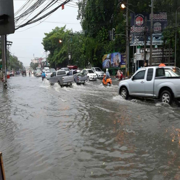

In [34]:
img_height = 180
img_width = 180

url = 'https://static.bangkokpost.com/media/content/20190919/c1_1753599.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((img_height, img_width))
img

In [35]:
img_array = np.array(img).astype('float64')
img_array = np.array([img_array, img_array])
img_gray = grayify.transform(img_array)
img_hog = hogify.transform(img_gray)
img_prepared = scalify.transform(img_hog)

In [36]:
predicted = sgd_clf.predict(img_prepared[0].reshape(1, -1))
proba = sgd_clf.predict_proba(img_prepared[0].reshape(1, -1))
print(predicted.item(), f'with confidence {np.max(proba)*100}%')

traffic with confidence 100.0%


# Pipeline

In [11]:
from sklearn.pipeline import Pipeline

In [15]:
pipeline = Pipeline([('gray', RGB2GrayTransformer()),
                     ('hog', HogTransformer(pixels_per_cell=(14, 14),
                                            cells_per_block=(2,2),
                                            orientations=9,
                                            block_norm='L2-Hys')),
                     ('scale', StandardScaler())])

In [16]:
pipeline.fit(X_train)

Pipeline(steps=[('gray', RGB2GrayTransformer()),
                ('hog',
                 HogTransformer(cells_per_block=(2, 2),
                                pixels_per_cell=(14, 14))),
                ('scale', StandardScaler())])

# Save and Load Model

In [1]:
import requests
from PIL import Image
from io import BytesIO

import numpy as np
import joblib

import skimage
from skimage.feature import hog
from skimage.transform import rescale
from sklearn.preprocessing import StandardScaler, Normalizer

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [3]:
# joblib.dump(sgd_clf, r'C:\ML_Models\sgdclfv2.pkl')

In [4]:
# joblib.dump(pipeline, r'C:\ML_Models\pipelinefit.pkl')

In [5]:
model = joblib.load(r'C:\ML_Models\sgdclfv2.pkl')
pipeline = joblib.load(r'C:\ML_Models\pipelinefit.pkl')

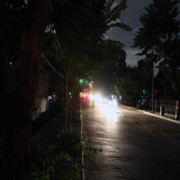

In [6]:
img_height = 180
img_width = 180

url = 'http://4.bp.blogspot.com/-dMrFYyVa2JI/UhWuzASZSMI/AAAAAAAAAKg/j1EHTU1HBNs/s1600/%E0%B8%96%E0%B8%99%E0%B8%99%E0%B9%80%E0%B8%9B%E0%B8%A3%E0%B8%B5%E0%B9%88%E0%B8%A2%E0%B8%A7.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = img.resize((img_height, img_width))
img

In [7]:
img_array = np.array(img).astype('float64')
img_array = np.array([img_array, img_array])

img_prepared = pipeline.transform(img_array)
# img_prepared = pipeline.transform(img_array)

In [8]:
predicted = model.predict(img_prepared[0].reshape(1, -1))
proba = model.predict_proba(img_prepared[0].reshape(1, -1))
print(predicted.item(), f'with confidence {np.max(proba)*100}%')

trash with confidence 100.0%
